# Figure 2: Motif configurations

**Description:** Analyzing significant motifs for all models (classification, cleavage, strength) using a variety of approaches. (Main Figure)

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import sequence, model_builder, classification_cleavage, motifs, relative_strength, genomic_context

from collections import defaultdict
from matplotlib_venn import venn3, venn3_circles
from statsmodels.stats.proportion import test_proportions_2indep

from venn import venn


In [5]:
## specify working directories

PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_02")
os.makedirs(OUTDIR, exist_ok = True)


## IMPORT DATA

### Motif threshold lists

In [6]:
with open(os.path.join(RESDIR, 'motif_list_negative.median_then_mean.cutoff_background.pickle'), mode = 'rb') as handle:
    final_background_list = pickle.load(handle)


In [7]:
variants_patterns = ['TATAAA', 'AGTAAA', 'TTTAAA', 'AATACA', 'CATAAA', 'GATAAA', 'AATATA', 'AATGAA', 'AAGAAA']

a_patterns = ['AAAAAA','AAAAA[C|G|T]','AAAA[C|G|T]A','AAA[C|G|T]AA','AA[C|G|T]AAA','A[C|G|T]AAAA']
t_patterns = ['TTTTTT','TTTTT[A|C|G]','TTTT[A|C|G]T','TTT[A|C|G]TT','TT[A|C|G]TTT','T[A|C|G]TTTT']
g_patterns = ['GGGGGG','GGGGG[A|C|T]','GGGG[A|C|T]G','GGG[A|C|T]GG','GG[A|C|T]GGG','G[A|C|T]GGGG']

variants = [x for x in variants_patterns if x in final_background_list]
a_rich = list(set([x for x in final_background_list if (re.search("|".join(a_patterns), x) is not None) and (x not in ['AATAAA','ATTAAA'])]))
t_rich = list(set([x for x in final_background_list if (re.search("|".join(t_patterns), x) is not None)]))
g_rich = list(set([x for x in final_background_list if (re.search("|".join(g_patterns), x) is not None)]))

gt_patterns = ['GTGT','TGTG','GTCT','CTGT','TCTG','TGTC']
gt_rich = list(set([x for x in final_background_list for gt in gt_patterns if (gt in x) and ("TGTA" not in x) and ((x.count("T") >= 3) or (x.count("G") >= 3) or (x.count("C") >= 3))]))

tgta_rich = list(set([x for x in final_background_list if ("TGTA" in x)]))


In [8]:
motif_counts = {
    'AATAAA'         : 1,
    'ATTAAA'         : 1,
    'Variants'       : len(variants),
    'A-rich'         : len(a_rich),
    'TGTA-containing': len(tgta_rich),
    'TGTA-only'      : 1,
    'T-rich'         : len(t_rich),
    'GT/CT-rich'     : len(gt_rich),
    'G-rich'         : len(g_rich),
}

for k,v in motif_counts.items(): print(f'{k:15} {v:3}')


AATAAA            1
ATTAAA            1
Variants          9
A-rich           15
TGTA-containing  43
TGTA-only         1
T-rich           16
GT/CT-rich      122
G-rich           16


In [9]:
center = 120
slop = 5

ideal_clv_config = {
    'AATAAA'     : {'motifs' : ['AATAAA'] , 'relpos' : -21, 'region' : (-30,-10)},
    'TGTA'       : {'motifs' : tgta_rich,   'relpos' : -43, 'region' : (-90,-10)},
    'T-rich_up'  : {'motifs' : t_rich,      'relpos' : -15, 'region' : (-20,0)},
    'GT/CT-rich' : {'motifs' : gt_rich,     'relpos' : +10, 'region' : (0,30)},
    'T-rich_dn'  : {'motifs' : t_rich,      'relpos' : +18, 'region' : (0,30)},
    'G-rich'     : {'motifs' : g_rich,      'relpos' : +37, 'region' : (20,90)},
}


## Analyze motif configurations

In [10]:
with open(os.path.join(DATADIR, 'comprehensive_predictions', 'reads3_golden_sites.processed.pickle'), mode = 'rb') as handle:
    gold_data = pickle.load(handle)


In [11]:
gold_sites = {}

for i,row in tqdm.tqdm(gold_data.iterrows()):
    
    rowkey = (row['gene'],row['chrom'],row['strand'])
    
    if not (rowkey in gold_sites):
        gold_sites[rowkey] = [row['start']]
    else:
        gold_sites[rowkey].append(row['start'])
    

32682it [00:03, 10135.53it/s]


In [12]:
gold_sites_labels = {}

for rk,pl in gold_sites.items():
    
    gold_sites_labels[rk] = {}
    
    if (len(pl) == 1):
        gold_sites_labels[rk][pl[0]] = 'single'
        
    else:
        spl = sorted(pl)
        g,c,s = rk
            
        gold_sites_labels[rk][spl[0]] = 'first' if (s == '+') else 'last'
        gold_sites_labels[rk][spl[-1]] = 'last' if (s == '+') else 'first'

        for p in spl[1:-1]:
            gold_sites_labels[rk][p] = 'middle'
        

In [13]:
gold_data['position'] = gold_data.apply(lambda row : gold_sites_labels.get((row['gene'],row['chrom'],row['strand']), {}).get(row['start'], 'NA'), axis = 1)
print(gold_data['position'].value_counts())


middle    9650
first     7962
last      7962
single    7108
Name: position, dtype: int64


#### Identifying motif positions relative to the max cleavage site

In [14]:
gold_data['idx_max_clv'] = gold_data['scorevec'].apply(lambda x : np.argmax(x) + 95)


In [15]:
for var,vdict in tqdm.tqdm(ideal_clv_config.items()):
    gold_data[f'idx_{var}'] = gold_data.apply(lambda row : motifs.find_motif(row['sequence'], vdict['motifs'], motif_type = 'all', region = vdict['region'], max_clv = row['idx_max_clv']), axis = 1)


100%|██████████| 6/6 [00:22<00:00,  3.82s/it]


In [16]:
for var in ideal_clv_config.keys():
    gold_data[f'pres_{var}'] = ~gold_data[f'idx_{var}'].isna()
    

In [17]:
gold_long = gold_data.copy()

gold_long = gold_long.explode('idx_AATAAA')
gold_long = gold_long.explode('idx_GT/CT-rich')
gold_long = gold_long.explode('idx_T-rich_dn')

print(gold_long.shape)


(815017, 54)


#### Identifying motif positions relative to the anchor motifs

In [18]:
gold_long['dist_T-rich_dn_GT/CT-rich'] = gold_long['idx_T-rich_dn'] - gold_long['idx_GT/CT-rich']
gold_long['dist_TGTA_AATAAA']          = gold_long['idx_TGTA']      - gold_long['idx_AATAAA']
gold_long['dist_T-rich_up_AATAAA']     = gold_long['idx_T-rich_up'] - gold_long['idx_AATAAA']
gold_long['dist_G-rich_dn_GT/CT-rich'] = gold_long['idx_G-rich']    - gold_long['idx_GT/CT-rich']

gold_long['order_T-rich_dn_GT/CT-rich'] = gold_long['dist_T-rich_dn_GT/CT-rich'].between(6,20)
gold_long['order_TGTA_AATAAA']          = gold_long['dist_TGTA_AATAAA'].apply(lambda x : np.any((x >= -46) & (x <= -6)))
gold_long['order_T-rich_up_AATAAA']     = gold_long['dist_T-rich_up_AATAAA'].apply(lambda x : np.any((x >= 6)))
gold_long['order_G-rich_dn_GT/CT-rich'] = gold_long['dist_G-rich_dn_GT/CT-rich'].apply(lambda x : np.any((x >= 6) & (x <= 56)))


In [19]:
condAATAAA = gold_long['pres_AATAAA']
condGTCT   = gold_long['pres_GT/CT-rich']
condTdn    = gold_long['pres_T-rich_dn']
condANCHOR = (condAATAAA & (condGTCT | condTdn))
print(condANCHOR.sum(), gold_long.loc[condANCHOR, 'cluster'].nunique())

condTwoDn  = condANCHOR & gold_long['order_T-rich_dn_GT/CT-rich']
condTGTA   = condANCHOR & gold_long['order_TGTA_AATAAA']
condTup    = condANCHOR & gold_long['order_T-rich_up_AATAAA']
condGdn    = condANCHOR & gold_long['order_G-rich_dn_GT/CT-rich']

countsANCHOR = {
    '100' : gold_long.loc[( condAATAAA) & (~condGTCT) & (~condTdn), 'cluster'].nunique(),
    '010' : gold_long.loc[(~condAATAAA) & ( condGTCT) & (~condTdn), 'cluster'].nunique(),
    '110' : gold_long.loc[( condAATAAA) & ( condGTCT) & (~condTdn), 'cluster'].nunique(),
    '001' : gold_long.loc[(~condAATAAA) & (~condGTCT) & ( condTdn), 'cluster'].nunique(),
    '101' : gold_long.loc[( condAATAAA) & (~condGTCT) & ( condTdn), 'cluster'].nunique(),
    '011' : gold_long.loc[(~condAATAAA) & ( condGTCT) & ( condTdn), 'cluster'].nunique(),
    '111' : gold_long.loc[( condAATAAA) & ( condGTCT) & ( condTdn), 'cluster'].nunique(),
}
print("Group counts for anchor motifs:\n", countsANCHOR)


countsACCESSORY = {
    '100' : gold_long.loc[( condTGTA) & (~condTup) & (~condGdn), 'cluster'].nunique(),
    '010' : gold_long.loc[(~condTGTA) & ( condTup) & (~condGdn), 'cluster'].nunique(),
    '110' : gold_long.loc[( condTGTA) & ( condTup) & (~condGdn), 'cluster'].nunique(),
    '001' : gold_long.loc[(~condTGTA) & (~condTup) & ( condGdn), 'cluster'].nunique(),
    '101' : gold_long.loc[( condTGTA) & (~condTup) & ( condGdn), 'cluster'].nunique(),
    '011' : gold_long.loc[(~condTGTA) & ( condTup) & ( condGdn), 'cluster'].nunique(),
    '111' : gold_long.loc[( condTGTA) & ( condTup) & ( condGdn), 'cluster'].nunique(),
}
print("Group counts for accesory motifs in anchored sites:\n", countsACCESSORY)


422189 13876
Group counts for anchor motifs:
 {'100': 3976, '010': 4662, '110': 6071, '001': 3024, '101': 3737, '011': 4361, '111': 4068}
Group counts for accesory motifs in anchored sites:
 {'100': 3498, '010': 1644, '110': 1034, '001': 1064, '101': 407, '011': 179, '111': 81}


#### Tabulate the number of optimally-positioned motifs

In [25]:
order_cols = ['order_T-rich_dn_GT/CT-rich','order_TGTA_AATAAA','order_T-rich_up_AATAAA','order_G-rich_dn_GT/CT-rich']

gold_long['number'] = 0
gold_long.loc[condANCHOR, 'number'] = (2 + gold_long.loc[condANCHOR, order_cols].to_numpy().sum(axis=1)).astype(int)

print(gold_long['number'].value_counts())


0    392828
3    202832
2    131427
4     75848
5     11563
6       519
Name: number, dtype: int64


#### Categorize sites into groups based on motifs present

In [28]:
category_ranks = {
    'CPSF-CstF anchors' : 1,
    
    '+CFI'     : 2,
    '+FIP1'    : 3,
    '+2ndCstF' : 4,
    '+hnRNP'   : 5,
    
    '+CFI +FIP1'      : 6,
    '+CFI +2ndCstF'   : 7,
    '+CFI +hnRNP'     : 8,
    '+FIP1 +2ndCstF'  : 9,
    '+FIP1 +hnRNP'    : 10,
    '+2ndCstF +hnRNP' : 11,
    
    '+CFI +FIP1 +2ndCstF'   : 12,
    '+CFI +FIP1 +hnRNP'     : 13,
    '+CFI +2ndCstF +hnRNP'  : 14,
    '+FIP1 +2ndCstF +hnRNP' : 15,
    
    '+CFI +FIP1 +2ndCstF +hnRNP' : 16,
}


gold_long['category'] = np.nan

gold_long.loc[condANCHOR, 'category'] = 'CPSF-CstF anchors'

gold_long.loc[( condTGTA) & (~condTup) & (~condTwoDn) & (~condGdn), 'category'] = '+CFI'
gold_long.loc[(~condTGTA) & ( condTup) & (~condTwoDn) & (~condGdn), 'category'] = '+FIP1'
gold_long.loc[(~condTGTA) & (~condTup) & ( condTwoDn) & (~condGdn), 'category'] = '+2ndCstF'
gold_long.loc[(~condTGTA) & (~condTup) & (~condTwoDn) & ( condGdn), 'category'] = '+hnRNP'

gold_long.loc[( condTGTA) & ( condTup) & (~condTwoDn) & (~condGdn), 'category'] = '+CFI +FIP1'
gold_long.loc[( condTGTA) & (~condTup) & ( condTwoDn) & (~condGdn), 'category'] = '+CFI +2ndCstF'
gold_long.loc[( condTGTA) & (~condTup) & (~condTwoDn) & ( condGdn), 'category'] = '+CFI +hnRNP'
gold_long.loc[(~condTGTA) & ( condTup) & ( condTwoDn) & (~condGdn), 'category'] = '+FIP1 +2ndCstF'
gold_long.loc[(~condTGTA) & ( condTup) & (~condTwoDn) & ( condGdn), 'category'] = '+FIP1 +hnRNP'
gold_long.loc[(~condTGTA) & (~condTup) & ( condTwoDn) & ( condGdn), 'category'] = '+2ndCstF +hnRNP'

gold_long.loc[( condTGTA) & ( condTup) & ( condTwoDn) & (~condGdn), 'category'] = '+CFI +FIP1 +2ndCstF'
gold_long.loc[( condTGTA) & ( condTup) & (~condTwoDn) & ( condGdn), 'category'] = '+CFI +FIP1 +hnRNP'
gold_long.loc[( condTGTA) & (~condTup) & ( condTwoDn) & ( condGdn), 'category'] = '+CFI +2ndCstF +hnRNP'
gold_long.loc[(~condTGTA) & ( condTup) & ( condTwoDn) & ( condGdn), 'category'] = '+FIP1 +2ndCstF +hnRNP'

gold_long.loc[( condTGTA) & ( condTup) & ( condTwoDn) & ( condGdn), 'category'] = '+CFI +FIP1 +2ndCstF +hnRNP'

gold_long['category_rank'] = gold_long['category'].apply(lambda x : category_ranks.get(x, np.nan))


In [67]:
# gold_priority_category = gold_long.loc[~gold_long['category'].isna()].copy().groupby('cluster').apply(lambda df : df.sort_values('category_rank', ascending = False).head(1))

ordering_combos = list(category_ranks.keys())
# ordering_combos = gold_priority_category.groupby(['category','number'])['our-models_strength'].describe().sort_values(['number','mean']).reset_index()['category'].tolist()

print(gold_priority_category[['cluster','category']].drop_duplicates()['cluster'].nunique())
print(gold_priority_category[['cluster','category']].drop_duplicates()['category'].value_counts().loc[ordering_combos])


13876
CPSF-CstF anchors             4876
+CFI                          2822
+FIP1                         1303
+2ndCstF                      1172
+hnRNP                         931
+CFI +FIP1                     836
+CFI +2ndCstF                  634
+CFI +hnRNP                    346
+FIP1 +2ndCstF                 315
+FIP1 +hnRNP                   149
+2ndCstF +hnRNP                132
+CFI +FIP1 +2ndCstF            188
+CFI +FIP1 +hnRNP               61
+CFI +2ndCstF +hnRNP            61
+FIP1 +2ndCstF +hnRNP           30
+CFI +FIP1 +2ndCstF +hnRNP      20
Name: category, dtype: int64


In [30]:
gold_priority_category['presence_CFI']     = gold_priority_category['category'].str.contains("CFI")
gold_priority_category['presence_FIP1']    = gold_priority_category['category'].str.contains("FIP1")
gold_priority_category['presence_2ndCstF'] = gold_priority_category['category'].str.contains("2ndCstF")
gold_priority_category['presence_hnRNP']   = gold_priority_category['category'].str.contains("hnRNP")

print(gold_priority_category['presence_CFI'].sum())
print(gold_priority_category['presence_FIP1'].sum())
print(gold_priority_category['presence_2ndCstF'].sum())
print(gold_priority_category['presence_hnRNP'].sum())


4968
2902
2552
1730


In [32]:
print(gold_priority_category.shape)
print(gold_priority_category[['cluster','presence_CFI','presence_FIP1','presence_2ndCstF','presence_hnRNP']].drop_duplicates().shape)


(13876, 69)
(13876, 5)


#### Tally sites with different motif configurations

##### Individual motifs

In [45]:
gold_counts = (gold_priority_category[['cluster','number','presence_CFI','presence_FIP1','presence_2ndCstF','presence_hnRNP']]
               .drop_duplicates()
               .melt(id_vars = ['cluster', 'number'])
               .groupby('variable')['value'].agg(['count','sum'])
               .assign(prop = lambda x : x['sum'] / x['count'] * 100)
               .reset_index())


,variable,count,sum,prop
0,presence_2ndCstF,13876,2552.0,18.391467
1,presence_CFI,13876,4968.0,35.802825
2,presence_FIP1,13876,2902.0,20.913808
3,presence_hnRNP,13876,1730.0,12.467570


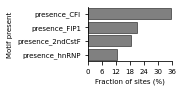

Corresponding data:
           variable  count     sum       prop
0  presence_2ndCstF  13876  2552.0  18.391467
1      presence_CFI  13876  4968.0  35.802825
2     presence_FIP1  13876  2902.0  20.913808
3    presence_hnRNP  13876  1730.0  12.467570


In [56]:
fig,ax = plt.subplots(1,1 ,figsize = (1.5,1))

sns.barplot(data = gold_counts, y = 'variable', x = 'prop', 
            order = ['presence_CFI','presence_FIP1','presence_2ndCstF','presence_hnRNP'],
            color = 'gray', edgecolor = 'black', linewidth = 0.5,
            saturation = 1, ax = ax)

ax.set_ylabel("Motif present")

ax.set_xlabel("Fraction of sites (%)")
ax.set_xlim(0,36)
ax.xaxis.set_major_locator(MultipleLocator(6))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'motif_configuration.fraction_by_individual.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(gold_counts)


##### Motif combinations

In [57]:
gold_counts = (gold_priority_category[['cluster','number','category']]
               .drop_duplicates()
               .groupby(['number','category']).size()
               .reset_index().rename(columns = {0 : 'count'})
              )

gold_counts['count_log10'] = np.log10(gold_counts['count'])
gold_counts['prop'] = gold_counts['count'] / gold_counts['count'].sum() * 100

gold_counts


,number,category,count,count_log10,prop
0,2,CPSF-CstF anchors,4876,3.688064,35.139810
1,3,+2ndCstF,1172,3.068928,8.446238
2,3,+CFI,2822,3.450557,20.337273
3,3,+FIP1,1303,3.114944,9.390314
4,3,+hnRNP,931,2.968950,6.709426
5,4,+2ndCstF +hnRNP,132,2.120574,0.951283
6,4,+CFI +2ndCstF,634,2.802089,4.569040
7,4,+CFI +FIP1,836,2.922206,6.024791
8,4,+CFI +hnRNP,346,2.539076,2.493514
9,4,+FIP1 +2ndCstF,315,2.498311,2.270107


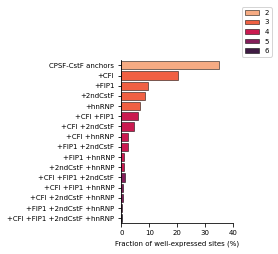

Corresponding data:
    number                    category  count  count_log10       prop
0        2           CPSF-CstF anchors   4876     3.688064  35.139810
1        3                    +2ndCstF   1172     3.068928   8.446238
2        3                        +CFI   2822     3.450557  20.337273
3        3                       +FIP1   1303     3.114944   9.390314
4        3                      +hnRNP    931     2.968950   6.709426
5        4             +2ndCstF +hnRNP    132     2.120574   0.951283
6        4               +CFI +2ndCstF    634     2.802089   4.569040
7        4                  +CFI +FIP1    836     2.922206   6.024791
8        4                 +CFI +hnRNP    346     2.539076   2.493514
9        4              +FIP1 +2ndCstF    315     2.498311   2.270107
10       4                +FIP1 +hnRNP    149     2.173186   1.073796
11       5        +CFI +2ndCstF +hnRNP     61     1.785330   0.439608
12       5         +CFI +FIP1 +2ndCstF    188     2.274158   1.354857


In [64]:
fig,ax = plt.subplots(1,1 ,figsize = (2,3))

sns.barplot(data = gold_counts, y = 'category', x = 'prop', order = ordering_combos,
            hue = 'number', dodge = False, palette = 'rocket_r', edgecolor = 'black', linewidth = 0.5,
            saturation = 1, ax = ax)

ax.set_ylabel("")

ax.set_xlabel("Fraction of well-expressed sites (%)")
ax.set_xlim(0,40)
ax.xaxis.set_major_locator(MultipleLocator(10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, f'motif_configuration.fraction_by_category.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(gold_counts)


In [166]:
gold_number_sum = gold_counts.loc[gold_counts['number'] > 0].groupby('number')['count'].agg('sum').reset_index()

gold_number_sum['prop']  = gold_number_sum['count'] / gold_number_sum['count'].sum()
gold_number_sum['label'] = gold_number_sum['number'].astype(str) + " (" + gold_number_sum['count'].astype(str) + ", " + (gold_number_sum['prop']*100).round(2).astype(str) + "%)"

print(gold_number_sum['count'].sum())
print(gold_number_sum)


13876
   number  count      prop             label
0       2   4876  0.351398  2 (4876, 35.14%)
1       3   6228  0.448833  3 (6228, 44.88%)
2       4   2412  0.173825  4 (2412, 17.38%)
3       5    340  0.024503    5 (340, 2.45%)
4       6     20  0.001441     6 (20, 0.14%)


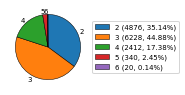

In [167]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(gold_number_sum['prop'], 
                        labels = gold_number_sum['number'].astype(str),
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, gold_number_sum['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, 'motif_configuration.pie.number_ordered_motifs.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Characterize sites with different motif configurations

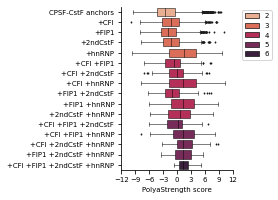

Wilcoxon rank-sum tests:
	5+ motifs vs 2 anchors only: 4.32E-58


In [65]:
fig,ax = plt.subplots(1,1 ,figsize = (2,3))

xvar = 'our-models_strength'
yvar = 'category'

sns.boxplot(data = gold_priority_category, y = yvar, x = xvar, order = ordering_combos,
            hue = 'number', dodge = False, palette = 'rocket_r',
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, 
            showfliers = True, ax = ax)

ax.set_ylabel("")

ax.set_xlabel("PolyaStrength score")
ax.set_xlim(-12,12)
ax.xaxis.set_major_locator(MultipleLocator(3))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'motif_configuration.polyastrength_by_category.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Wilcoxon rank-sum tests:")
print(f"\t5+ motifs vs 2 anchors only: {st.ranksums(gold_priority_category.loc[gold_priority_category['number'] >= 5, xvar], gold_priority_category.loc[gold_priority_category['number'] == 2, xvar])[1]:.02E}")


#### Are sites with more optimally-positioned motifs located in genes with fewer pA sites? Single site genes?

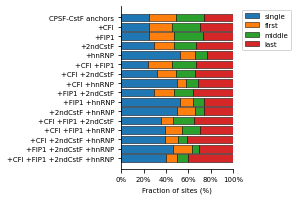

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples

Proportion of single sites-
	5+ motifs vs 2 anchors only: 4.32E-07

Proportion of last sites-
	5+ motifs vs 2 anchors only: 5.69E-04

Corresponding data:
position                        first       last     middle     single
category                                                              
CPSF-CstF anchors           24.138638  25.902379  25.123052  24.835931
+CFI                        20.588235  29.943303  24.840539  24.627923
+FIP1                       21.949348  27.244820  25.633154  25.172678
+2ndCstF                    18.344710  33.105802  19.709898  28.839590
+hnRNP                      13.748657  23.093448  10.526316  52.631579
+CFI +FIP1                  21.291866  32.655502  22.368421  23.684211
+CFI +2ndCstF               16.403785  34.069401  17.192429  32.334385
+CFI +hnRNP                  8.092486  30.924855  10.982659  50.000000
+FIP1 +2ndCstF              18.095238  35.5

In [68]:
gold_position_sum = (
    gold_priority_category[['cluster','number','category','position']].drop_duplicates()
    .groupby(['category','number','position']).size()
    .agg({
        'count' : lambda x : x,
        'prop' : lambda x : x / x.sum(level = 0) * 100
    })
    .unstack(level = 0).reset_index()
)

gold_position_wide = gold_position_sum.pivot(index = 'category', columns = 'position', values = 'prop').loc[ordering_combos[::-1]]



fig,ax = plt.subplots(1,1, figsize = (2,3))

ys = list(range(len(ordering_combos)))
sums = [0]*len(ordering_combos)

for p in ['single','first','middle','last']:
    
    widths = gold_position_wide[[p]].to_numpy().flatten()
    ax.barh(ys, widths, left = sums, edgecolor = 'black', linewidth = 0.5, label = p)
    
    for i,w in enumerate(widths):
        sums[i] += w
        
ax.set_xlabel("Fraction of sites (%)")
ax.set_xlim(0,100)
ax.xaxis.set_major_formatter(PercentFormatter())

ax.set_ylabel("")
ax.set_yticks(ys)
ax.set_yticklabels(ordering_combos[::-1])
        
ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'motif_configuration.position_distribution_by_category.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples")

print("\nProportion of single sites-")

prop_test = test_proportions_2indep(count1 = gold_position_sum.loc[(gold_position_sum['number'] >= 5) & (gold_position_sum['position'] == "single"), 'count'].sum(), 
                                     nobs1  = gold_position_sum.loc[(gold_position_sum['number'] >= 5), 'count'].sum(),
                                     count2 = gold_position_sum.loc[(gold_position_sum['number'] == 2) & (gold_position_sum['position'] == "single"), 'count'].sum(), 
                                     nobs2  = gold_position_sum.loc[(gold_position_sum['number'] == 2), 'count'].sum())

print(f"\t5+ motifs vs 2 anchors only: {prop_test[1]:.02E}")


print("\nProportion of last sites-")

prop_test = test_proportions_2indep(count1 = gold_position_sum.loc[(gold_position_sum['number'] >= 5) & (gold_position_sum['position'] == "last"), 'count'].sum(), 
                                     nobs1  = gold_position_sum.loc[(gold_position_sum['number'] >= 5), 'count'].sum(),
                                     count2 = gold_position_sum.loc[(gold_position_sum['number'] == 2) & (gold_position_sum['position'] == "last"), 'count'].sum(), 
                                     nobs2  = gold_position_sum.loc[(gold_position_sum['number'] == 2), 'count'].sum())

print(f"\t5+ motifs vs 2 anchors only: {prop_test[1]:.02E}")


print("\nCorresponding data:")
print(gold_position_wide.loc[ordering_combos])


#### Are sites with more optimally-positioned motifs found in higher expressed genes?

In [69]:
with open(os.path.join(PROJECT,"data","data_preparation","scoring_dictionary","human.exclude_4.all.adj_var.comb.filt.scoring_dictionary.pickle"), mode = 'rb') as handle:
    reads_dict = pickle.load(handle)

gene_list = list(itertools.chain.from_iterable([g.split(";") for g in gold_long['gene'].unique()]))
gene_scores = {}

with open(os.path.join(PROJECT, 'reference', 'hg38_old', 'combined_features', 'comprehensive_annotation.minUn.minNC.bed'), mode = 'r') as handle:
    for line in tqdm.tqdm(handle):
        
        gchrom, gstart, gend, glabel, _, gstrand = [int(float(x)) if i in [1,2] else x for i,x in enumerate(line.strip().split("\t"))]
        gname = glabel.split(",")[0]
        
        if ((gname,gchrom,gstrand) in gene_scores):
            continue
        
        if (gname not in gene_list):
            continue
        
        greads = 0
        
        for gpos in range(gstart, gend):
            greads += reads_dict.get((gstrand,gchrom,gpos), 0)
        
        gene_scores[(gname,gchrom,gstrand)] = greads


32292it [10:38, 50.55it/s] 


In [70]:
gold_priority_category['gene_reads'] = gold_priority_category.apply(lambda row : np.max([gene_scores.get((_,row['chrom'],row['strand']),0) for _ in row['gene'].split(";")]), axis = 1)
gold_priority_category['gene_reads_log1p'] = np.log10(gold_priority_category['gene_reads'] + 1)


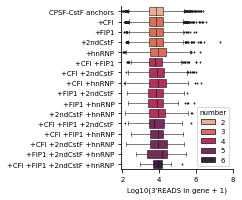

Wilcoxon rank-sum tests:
	5+ motifs vs 2 anchors only  : 3.06E-01


In [71]:
fig,ax = plt.subplots(1,1 ,figsize = (2,3))

xvar = 'gene_reads_log1p'
yvar = 'category'

sns.boxplot(data = gold_priority_category, y = yvar, x = xvar, order = ordering_combos,
            hue = 'number', dodge = False, palette = 'rocket_r',
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, 
            showfliers = True, ax = ax)

ax.set_ylabel("")

ax.set_xlabel("Log10(3'READS in gene + 1)")
ax.set_xlim(1.95,8)
ax.xaxis.set_major_locator(MultipleLocator(2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'motif_configuration.gene_reads_by_category.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Wilcoxon rank-sum tests:")
print(f"\t5+ motifs vs 2 anchors only  : {st.ranksums(gold_priority_category.loc[gold_priority_category['number'] >= 5, xvar], gold_priority_category.loc[gold_priority_category['number'] == 2, xvar])[1]:.02E}")


#### What type of genes contain 4 or 5+ optimally-positioned motifs?

In [72]:
## Uncomment to get gene lists for gene ontology
# print(gold_priority_category.loc[gold_priority_category['number'] >= 5, 'gene'].nunique())
# print("\n".join(gold_priority_category.loc[gold_priority_category['number'] >= 5, 'gene'].unique().tolist()))

go_res = pd.read_csv(os.path.join(OUTDIR, "gene_ontology.bp_all.genes_with_5-6_motifs.txt"), sep = "\t")
go_res['Label'] = go_res['Term'].str.split("~").str[1].str.capitalize()
go_res['PValue_minlog'] = -1 * np.log10(go_res['PValue'])
go_res['Benjamini_minlog'] = -1 * np.log10(go_res['Benjamini'])
print(go_res.shape)


(440, 17)


In [73]:
go_res.loc[go_res['Include'] == 'y', ['Label','PValue','Benjamini','Benjamini_minlog']].sort_values('PValue').head(10)


,Label,PValue,Benjamini,Benjamini_minlog
0,Positive regulation of cellular process,6.510000e-11,3.070000e-07,6.512862
2,Positive regulation of macromolecule metabolic...,3.720000e-08,4.630000e-05,4.334419
3,Cellular response to stress,3.930000e-08,4.630000e-05,4.334419
7,"Positive regulation of transcription, dna-temp...",5.270000e-07,2.520000e-04,3.598599
13,Positive regulation of gene expression,1.900000e-06,6.380000e-04,3.195179
16,Chromosome organization,8.360000e-06,2.213848e-03,2.654852
19,Embryonic organ morphogenesis,2.030000e-05,4.530534e-03,2.343851
20,Covalent chromatin modification,2.090000e-05,4.530534e-03,2.343851
22,Cellular component organization,3.290000e-05,6.729386e-03,2.172025
26,Embryonic organ development,5.460000e-05,9.520206e-03,2.021354


In [74]:
print("\n".join(go_res.loc[go_res['Include'] == 'y', 'Term'].unique()))


GO:0048522~positive regulation of cellular process
GO:0010604~positive regulation of macromolecule metabolic process
GO:0033554~cellular response to stress
GO:0045893~positive regulation of transcription, DNA-templated
GO:0010628~positive regulation of gene expression
GO:0051276~chromosome organization
GO:0048562~embryonic organ morphogenesis
GO:0016569~covalent chromatin modification
GO:0016043~cellular component organization
GO:0048568~embryonic organ development


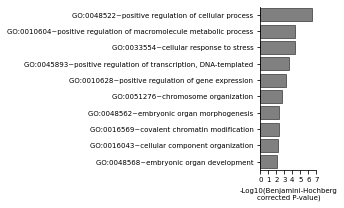

In [75]:
fig,ax = plt.subplots(1,1, figsize = (1,3))

sns.barplot(data = go_res.loc[go_res['Include'] == 'y'].sort_values('PValue_minlog', ascending = False).head(10),
            y = 'Term', x = 'Benjamini_minlog',
            color = 'gray', edgecolor = 'black', linewidth = 0.5,
            ax = ax)


ax.set_ylabel("")

ax.set_xlabel("-Log10(Benjamini-Hochberg\ncorrected P-value)")
ax.set_xlim(0,7)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'motif_configuration.gene_ontology.top_pval_5-6_motifs.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()
